In [2]:
import logging
import os
import sys
import xarray as xr
import pandas as pd
import requests
import gzip
from io import StringIO

ModuleNotFoundError: No module named 'xarray'

In [2]:
def Data_cleaning(filename):
    ####################################### READ RAW DATA ###########################################
    # Lees het bestand in
    with gzip.open(filename, 'rt', encoding='utf-8') as f:
        lines = f.readlines()
    
    # Vind de laatste regel die met '#' begint en gebruik die als kolomnamen
    header_line = ""
    for line in reversed(lines):
        if line.startswith("#"):
            header_line = line.strip("#").strip()
            break
    
    # Filter alle datalijnen (niet met # beginnend)
    data_lines = [line for line in lines if not line.startswith("#")]
    
    # Zet het geheel weer in een stringbuffer
    data_str = ''.join(data_lines)
    data_io = StringIO(data_str)
    
    # Zet ook de kolomnamen in een aparte stringbuffer en voeg samen
    full_str = header_line + '\n' + data_str
    full_io = StringIO(full_str)
    
    # Lees het in met pandas
    df = pd.read_fwf(full_io)

    ####################################### DATA CLEANING ###########################################
    df['DATE'] = df["DTG"]
    df['TIME'] = df['LOCATION'].str[:2]
    df['CITY'] = df['NAME']
    df.drop(['LOCATION','DTG', 'NAME', 'LATITUDE', 'LONGITUDE', 'ALTITUDE', 'QN_GLOB_10', 'QX_GLOB_10', 'SQ_10'], axis=1, inplace=True)
    
    if 'Unnamed: 3' in df.columns:
        df.drop(columns=['Unnamed: 3'], inplace=True)
        
    if 'Unnamed: 4' in df.columns:
        df.drop(columns=['Unnamed: 4'], inplace=True)

    df = df[df['CITY'].str.contains("Rotterdam", case=False, na=False)].copy()
    df.drop(['CITY'], axis=1, inplace=True)
    ####################################### DATA TRANSFORMATION ###########################################

    df = df.groupby(['DATE', 'TIME'])['Q_GLOB_10'].mean().reset_index()

    return df

In [3]:
#om te testen
link = r"C:\Users\KaasT\Documents\Datalab V\kis_tos_202401.gz"
Data_cleaning(link)

,DATE,TIME,Q_GLOB_10
0,2024-01-01,00,0.0
1,2024-01-01,01,0.0
2,2024-01-01,02,0.0
3,2024-01-01,03,0.0
4,2024-01-01,04,0.0
...,...,...,...
740,2024-01-31,20,0.0
741,2024-01-31,21,0.0
742,2024-01-31,22,0.0
743,2024-01-31,23,0.0


In [14]:
file_names = [f"C:/Users/KaasT/Documents/Datalab V/kis_tos_{date}.gz" for date in range(202401, 202413)]

cleaned_data_frames = []

for file in file_names:
    cleaned_df = Data_cleaning(file)
    cleaned_data_frames.append(cleaned_df)

df = pd.concat(cleaned_data_frames, ignore_index=True)
df

,DATE,TIME,Q_GLOB_10
0,2024-01-01,00,0.0
1,2024-01-01,01,0.0
2,2024-01-01,02,0.0
3,2024-01-01,03,0.0
4,2024-01-01,04,0.0
...,...,...,...
8791,2024-12-31,20,0.0
8792,2024-12-31,21,0.0
8793,2024-12-31,22,0.0
8794,2024-12-31,23,0.0


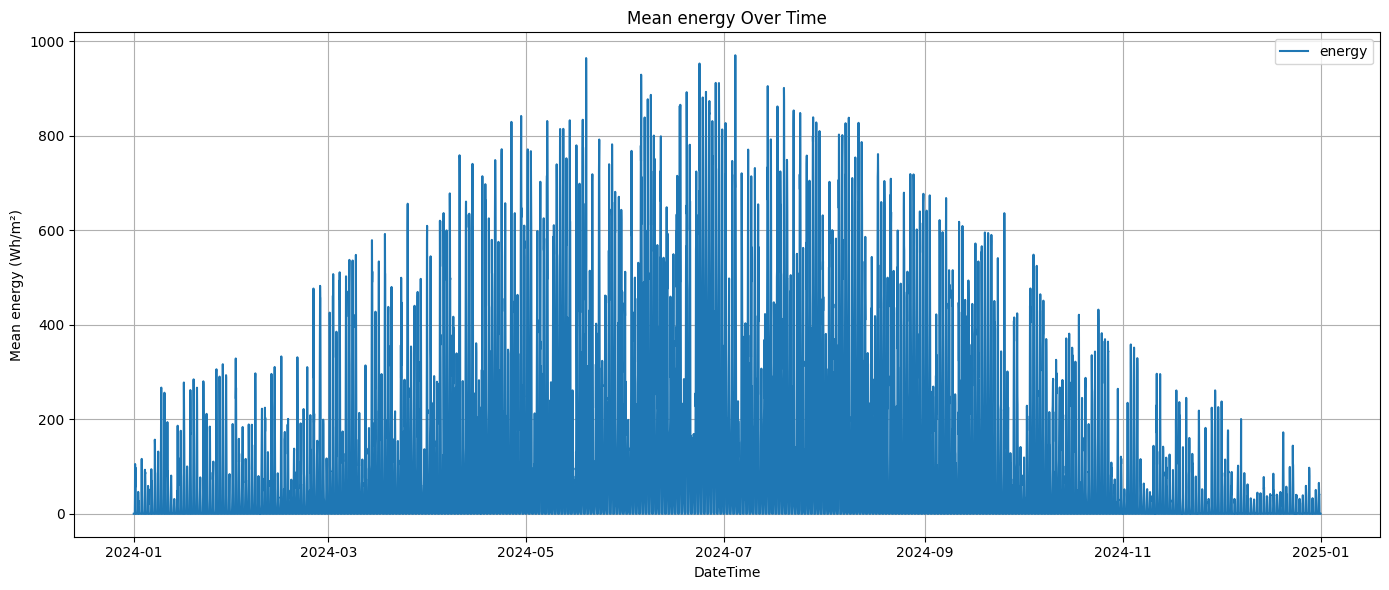

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Combine DATE and TIME into one datetime column
df['DATETIME'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'].astype(str).str.zfill(2), format='%Y-%m-%d %H')

# Step 2: Group and calculate mean
df_grouped = df.groupby('DATETIME')['Q_GLOB_10'].mean().reset_index()

# Step 3: Plot
plt.figure(figsize=(14,6))
plt.plot(df_grouped['DATETIME'], df_grouped['Q_GLOB_10'], label='energy')
plt.xlabel('DateTime')
plt.ylabel('Mean energy (Wh/m²)')
plt.title('Mean energy Over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

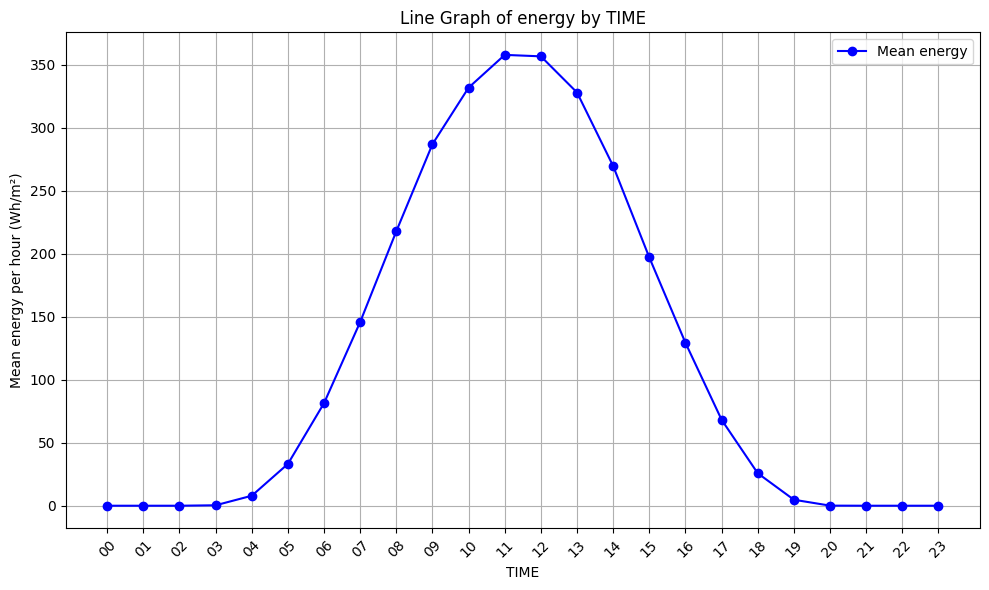

In [16]:
import matplotlib.pyplot as plt

# Ensure TIME is treated as a string or categorical data for proper plotting
df['TIME'] = df['TIME'].astype(str)

# Group by TIME and calculate the mean Q_GLOB_10
df_grouped = df.groupby('TIME')['Q_GLOB_10'].mean().reset_index()

# Plotting the line graph
plt.figure(figsize=(10, 6))
plt.plot(df_grouped['TIME'], df_grouped['Q_GLOB_10'], marker='o', color='b', label='Mean energy')
plt.xlabel('TIME')
plt.ylabel('Mean energy per hour (Wh/m²)')
plt.title('Line Graph of energy by TIME')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

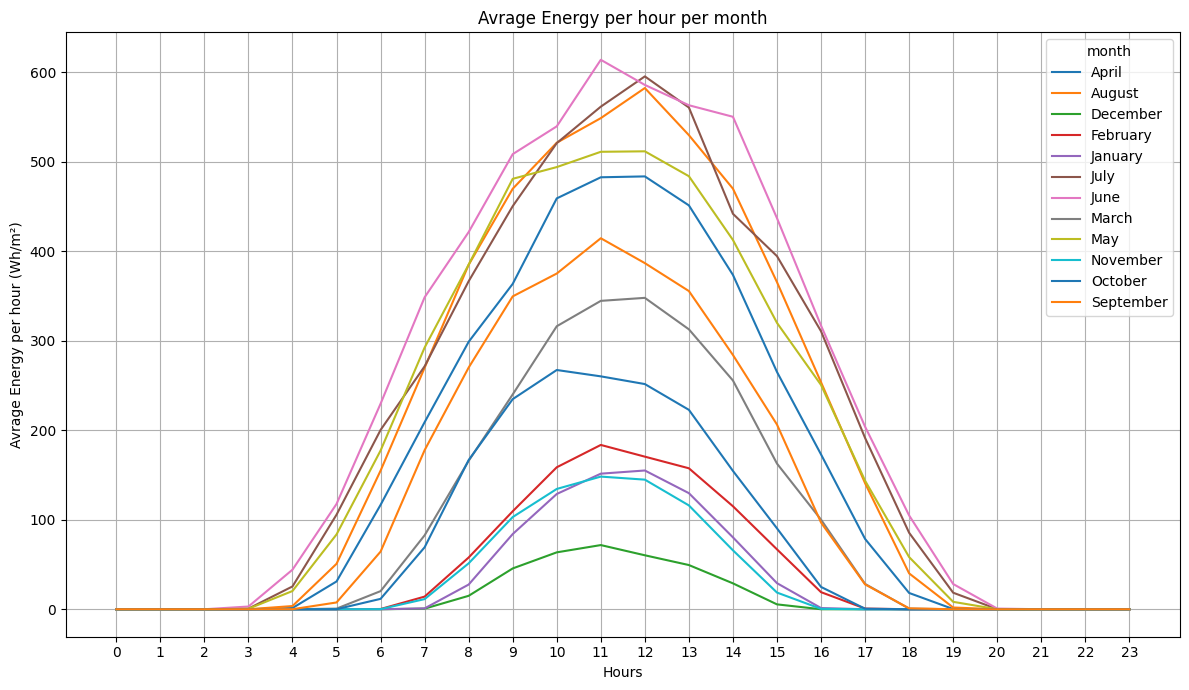

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Zorg dat DATE en TIME goed gecombineerd zijn
df['DATE'] = pd.to_datetime(df['DATE'])

# Voeg kolom toe voor maandnaam of maandnummer
df['MONTH'] = df['DATE'].dt.strftime('%B')  # Of '%m' voor maandnummer

# Zorg dat TIME numeriek is (bijv. van string naar int)
df['TIME'] = df['TIME'].astype(int)

# Groepeer per maand en uur, en bereken gemiddelde
df_grouped = df.groupby(['MONTH', 'TIME'])['Q_GLOB_10'].mean().reset_index()

# Optioneel: maanden in juiste volgorde (indien je maandnamen gebruikt)
maand_volgorde = ['January', 'February', 'March', 'April', 'May', 'June',
                  'July', 'August', 'September', 'October', 'November', 'December']
df_grouped['MONTH'] = pd.Categorical(df_grouped['MONTH'], categories=maand_volgorde, ordered=True)

# Plotten
plt.figure(figsize=(12, 7))

for maand in df_grouped['MONTH'].unique():
    maand_data = df_grouped[df_grouped['MONTH'] == maand]
    plt.plot(maand_data['TIME'], maand_data['Q_GLOB_10'], label=maand)

plt.xlabel('Hours')
plt.ylabel('Avrage Energy per hour (Wh/m²)')
plt.title('Avrage Energy per hour per month')
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend(title='month')
plt.tight_layout()
plt.show()


### Adding another year

In [2]:
import pandas as pd
production_df = pd.read_csv("data/solar_strength.csv", index_col="DATE")
production_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
DATE,,,,,,,,,,,,,,,,,,,,,
27-12-2024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.17,8.00,29.50,...,18.17,3.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28-12-2024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.33,12.83,37.67,...,37.50,7.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29-12-2024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,3.17,13.33,...,16.33,3.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30-12-2024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,5.17,22.00,...,32.83,11.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31-12-2024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.17,6.00,32.83,...,41.17,9.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
production_df.index = pd.to_datetime(production_df.index, dayfirst=True)

# Step 2: Duplicate and shift index by one year
df_next_year = production_df.copy()
df_next_year.index = df_next_year.index + pd.DateOffset(years=1)

# Step 3: Concatenate the original and duplicated data
df_two_years = pd.concat([production_df, df_next_year])

# Optional: Sort the index
df_two_years = df_two_years.sort_index()

df_two_years.index = df_two_years.index.strftime('%d-%m-%Y')

df_two_years = df_two_years[~df_two_years.index.duplicated(keep='first')]

# Done!
df_two_years

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
DATE,,,,,,,,,,,,,,,,,,,,,
01-01-2024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,4.50,36.17,...,97.17,8.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02-01-2024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,13.50,46.33,...,8.33,1.67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
03-01-2024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.17,9.67,44.17,...,12.00,5.83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
04-01-2024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,8.67,53.17,...,67.67,18.67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05-01-2024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.33,8.33,31.50,...,27.33,7.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27-12-2025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.17,8.00,29.50,...,18.17,3.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28-12-2025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.33,12.83,37.67,...,37.50,7.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29-12-2025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,3.17,13.33,...,16.33,3.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df_two_years.to_csv("data/solar_2years.csv", index_label="DATE")